## Downloading dataset from Kaggle

In [1]:
# Installing Kaggle library
!pip install -q kaggle

In [2]:
"""
Get your Kaggle API token. To do this:

Log in to Kaggle.
Go to your account page (click on your profile picture on the top right, then "My Account").
Scroll down to the API section and click on "Create New API Token". This will download a JSON file (kaggle.json) to your computer.
"""
# Uploading json file to Colab

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aarishmaqsood","key":"1d53d5d363ca804fc425ae4634510d36"}'}

In [3]:
# Move the kaggle.json file into the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download datasets from Kaggle
!kaggle competitions download -c birds23sp

100% 9.19G/9.20G [01:14<00:00, 126MB/s]
100% 9.20G/9.20G [01:14<00:00, 132MB/s]


In [5]:
# Unzip the downloaded files
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds/train/535/178aee8e17ce4c5d91704f25e0bfbb3b.jpg  
  inflating: birds/train/535/24d7923305134b49a3ef6f86186620d0.jpg  
  inflating: birds/train/535/521c8eeca4104aa08a73bc3f5baf6837.jpg  
  inflating: birds/train/535/5aa7cea9fc2648b5a0321c80fbbbc7ed.jpg  
  inflating: birds/train/535/5b696e2e34724cd79f09594af2f25d54.jpg  
  inflating: birds/train/535/5bb145ba9e7149f5b51a9b2a49731ce4.jpg  
  inflating: birds/train/535/6316fab78cc3446eb41a375aa7103b02.jpg  
  inflating: birds/train/535/66eb23f1980147fb95b0efca733c3e76.jpg  
  inflating: birds/train/535/767c16bbcbaf423cba30f2c6e910785f.jpg  
  inflating: birds/train/535/833d1dd47df946d796fb05de700527df.jpg  
  inflating: birds/train/535/8c1e2eca0f7243ffa7357bfb9a609d60.jpg  
  inflating: birds/train/535/91caf8a46020402383b9caaafbc2852e.jpg  
  inflating: birds/train/535/96d2a466540445c6b915862079aef6c1.jpg  
  inflating: birds/train/535/9bde67300b9e425784fe2508a183d502.jpg

## Import necessary libraries

In [6]:
import os
import cv2
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 

## Paths

In [7]:
# Set your dataset path
train_data_dir = r'/content/birds/train'
test_data_dir = r'/content/birds/test'

## Image Data Generators

In [8]:
# Set constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
# Create ImageDataGenerators for train and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 38562 images belonging to 555 classes.
Found 10000 images belonging to 1 classes.


## Model

In [11]:
num_classes = len(train_generator.class_indices)

In [12]:
vgg = VGG19(input_shape = (*IMG_SIZE, 3), weights = 'imagenet', include_top = False)

80134624/80134624 [==============================] - 0s 0us/step


In [23]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

In [24]:
# Train the model
history = model.fit(train_generator, validation_data=test_generator, epochs=10, batch_size = BATCH_SIZE)

Epoch 1/10
1206/1206 [==============================] - 601s 497ms/step - loss: 10.3332 - accuracy: 0.0601 - val_loss: 11401.5898 - val_accuracy: 0.0000e+00
Epoch 2/10
1206/1206 [==============================] - 598s 496ms/step - loss: 3.8676 - accuracy: 0.4489 - val_loss: 13051.0068 - val_accuracy: 0.0000e+00
Epoch 3/10
1206/1206 [==============================] - 593s 492ms/step - loss: 2.5643 - accuracy: 0.6129 - val_loss: 14269.0830 - val_accuracy: 0.0023
Epoch 4/10
1206/1206 [==============================] - 600s 497ms/step - loss: 1.9611 - accuracy: 0.6984 - val_loss: 16280.9424 - val_accuracy: 0.0000e+00
Epoch 5/10
1206/1206 [==============================] - 592s 491ms/step - loss: 1.6247 - accuracy: 0.7526 - val_loss: 17141.7891 - val_accuracy: 9.0000e-04
Epoch 6/10
1206/1206 [==============================] - 591s 490ms/step - loss: 1.4938 - accuracy: 0.7804 - val_loss: 18611.5527 - val_accuracy: 1.0000e-04
Epoch 7/10
1206/1206 [==============================] - 589s 489ms/

## Visualization

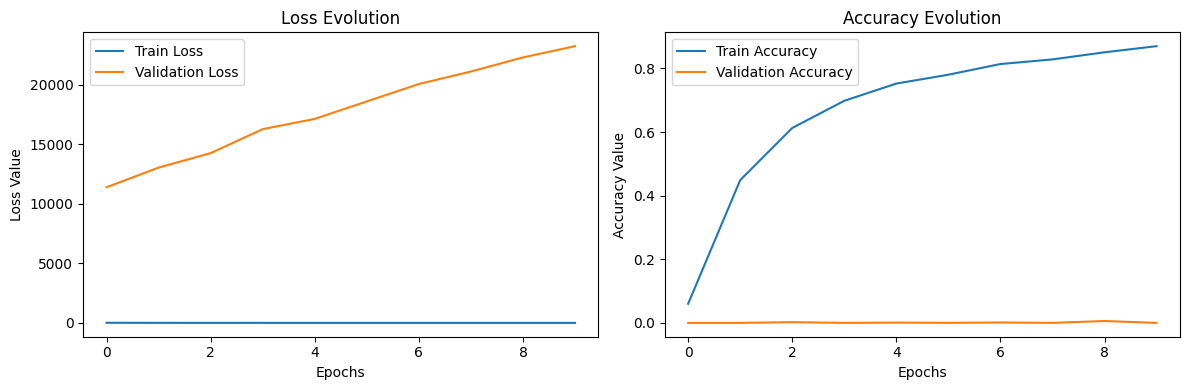

In [25]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

In [26]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, batch_size = BATCH_SIZE)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

313/313 [==============================] - 122s 391ms/step - loss: 23253.4551 - accuracy: 0.0000e+00
Test Loss:  23253.455078125
Test Accuracy:  0.0


## Prediction

In [27]:
# Make predictions
test_generator.reset()
predictions = model.predict(test_generator)

# The predictions are in the form of probabilities for each class, to get the predicted class, take the argmax
predicted_classes = predictions.argmax(axis=1)

313/313 [==============================] - 120s 383ms/step


In [ ]:
# Get true class labels
true_classes = test_generator.classes

# Generate classification report
report = classification_report(true_classes, predicted_classes)

print(report)

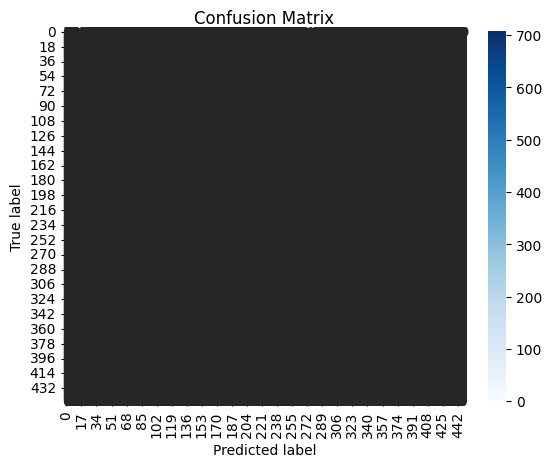

In [30]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from sklearn.model_selection import train_test_split

In [46]:
# load train labels from csv file
train_labels = pd.read_csv('/content/birds/labels.csv')
train_labels['class'] = train_labels['class'].astype('str')

# Split the data into train and validation sets
train_df, validation_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['class'], random_state=42)

# Convert the 'class' column to string first
train_df['class'] = train_df['class'].astype('str')
validation_df['class'] = validation_df['class'].astype('str')

# Add class folder to the 'path' column
train_df['path'] = train_df['class'] + '/' + train_df['path']
validation_df['path'] = validation_df['class'] + '/' + validation_df['path']

# Create a ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

# Use flow_from_dataframe to read images from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/birds/train',
    x_col='path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory='/content/birds/train',
    x_col='path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 30849 validated image filenames belonging to 555 classes.
Found 7713 validated image filenames belonging to 555 classes.


In [47]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [48]:
# Create the base model
base_model = VGG19(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer for your classes
predictions = Dense(555, activation='softmax')(x) # 555 because you mentioned classes upto 554

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# 4. Train your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
965/965 [==============================] - 579s 584ms/step - loss: 6.3942 - accuracy: 0.0021 - val_loss: 6.2688 - val_accuracy: 0.0025
Epoch 2/5
965/965 [==============================] - 542s 561ms/step - loss: 6.2772 - accuracy: 0.0020 - val_loss: 6.2655 - val_accuracy: 0.0027
Epoch 3/5
965/965 [==============================] - 533s 552ms/step - loss: 6.2753 - accuracy: 0.0026 - val_loss: 6.2653 - val_accuracy: 0.0027
Epoch 4/5
965/965 [==============================] - 532s 551ms/step - loss: 6.2738 - accuracy: 0.0024 - val_loss: 6.2644 - val_accuracy: 0.0027
Epoch 5/5
381/965 [==========>...................] - ETA: 4:23 - loss: 6.2720 - accuracy: 0.0027

KeyboardInterrupt: ignored

In [49]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [50]:
import efficientnet.tfkeras as efn

# Create the base model
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)

# Rest of the code remains the same

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer for your classes
predictions = Dense(555, activation='softmax')(x) # 555 because you mentioned classes upto 554

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Train your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

# Evaluate your model
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/5
965/965 [==============================] - 536s 509ms/step - loss: 3.4249 - accuracy: 0.2598 - val_loss: 2.6031 - val_accuracy: 0.3757
Epoch 2/5
965/965 [==============================] - 484s 501ms/step - loss: 1.6663 - accuracy: 0.5473 - val_loss: 1.7868 - val_accuracy: 0.5419
Epoch 3/5
965/965 [==============================] - 473s 489ms/step - loss: 1.1649 - accuracy: 0.6620 - val_loss: 1.5574 - val_accuracy: 0.5973
Epoch 4/5
965/965 [==============================] - 473s 490ms/step - loss: 0.8733 - accuracy: 0.7385 - val_loss: 1.7619 - val_accuracy: 0.5723
Epoch 5/5
242/242 [==============================] - 96s 395ms/step - loss: 1.8461 - accuracy: 0.5897
Validation accuracy: 0.5896538496017456


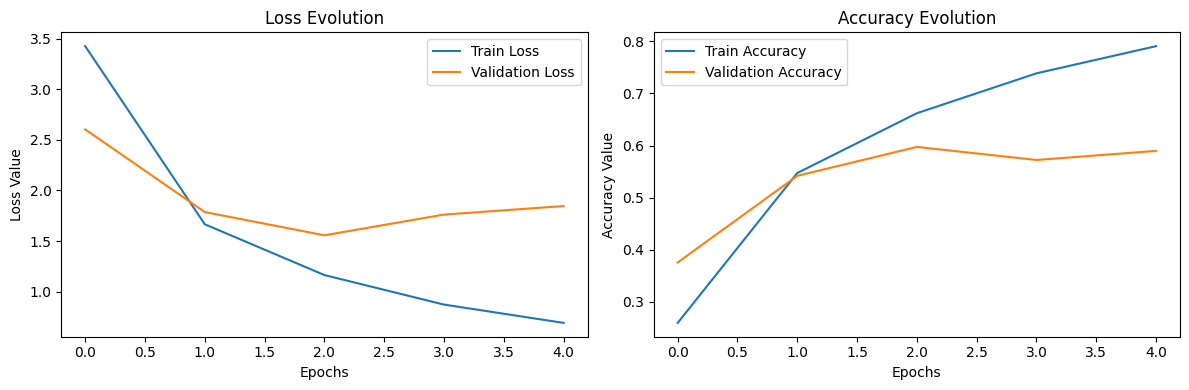

In [57]:
# Store the epoch data
history = {
    'loss': [3.4249, 1.6663, 1.1649, 0.8733, 0.6926],
    'accuracy': [0.2598, 0.5473, 0.6620, 0.7385, 0.7906],
    'val_loss': [2.6031, 1.7868, 1.5574, 1.7619, 1.8461],
    'val_accuracy': [0.3757, 0.5419, 0.5973, 0.5723, 0.5897]
}

# Create subplots
plt.figure(figsize=(12, 4))

# Plot Loss data
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy data
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)

# load test paths from csv file
test_paths = pd.read_csv('/content/birds/sample.csv')
test_paths['path'] = test_paths['path'].apply(lambda x: os.path.join('test', '0', os.path.basename(x)))

# Create a test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_paths,
    directory='/content/birds',
    x_col='path',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None, # because we have no labels
    shuffle=False)   # keep data in same order as labels

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=1)

Found 10000 validated image filenames.
313/313 [==============================] - 126s 397ms/step


In [63]:
train_generator.classes.count(403)

63